# Pretrained VGG16 - Keras

## Feature extraction 

### Imports

In [1]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, BatchNormalization
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator

import matplotlib.pyplot as plt

### Compatibility issues

In [2]:
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession

config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)

### Preprocess data

In [3]:
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)
test_datagen = ImageDataGenerator(rescale=1./255)

In [4]:
train_dir = '/home/carlo/Documentos/Datasets/chest_xray/train'
test_dir = '/home/carlo/Documentos/Datasets/chest_xray/test'
val_dir = '/home/carlo/Documentos/Datasets/chest_xray/val'

In [5]:
IMAGE_SIZE = 150

train_generator = train_datagen.flow_from_directory(
    train_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=32,
    class_mode='binary'
)

test_generator = test_datagen.flow_from_directory(
    test_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=16,
    class_mode='binary'
)

val_generator = test_datagen.flow_from_directory(
    val_dir,
    target_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=16,
    class_mode='binary'
)

Found 5216 images belonging to 2 classes.
Found 624 images belonging to 2 classes.
Found 16 images belonging to 2 classes.


### Import and load VGG16

In [6]:
conv_base = VGG16(
    weights='imagenet',
    include_top=False, 
    input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)
)

In [7]:
conv_base.trainable = False
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

### Create a top network

In [8]:
model = Sequential()
model.add(conv_base)

In [9]:
model.add(Flatten())
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))

model.add(Dense(1, activation='sigmoid'))

In [10]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
batch_normalization (BatchNo (None, 8192)              32768     
_________________________________________________________________
dropout (Dropout)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
batch_normalization_1 (Batch (None, 512)               2048      
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0

### Compile and train

In [11]:
from tensorflow.keras.optimizers import Adam
opt = Adam(1e-4)

model.compile(
    optimizer=opt,
    loss='binary_crossentropy',
    metrics=['accuracy']
)

In [12]:
from tensorflow.keras.callbacks import EarlyStopping

earlyStopping = EarlyStopping(
    monitor='val_accuracy',
    patience=10,
    restore_best_weights=True
)

In [13]:
history = model.fit_generator(
    train_generator,
    steps_per_epoch=163,
    epochs=10,
    validation_data=val_generator,
    validation_steps=1,
    callbacks=[earlyStopping]
)

Epoch 1/10
163/163 [==============================] - 60s 369ms/step - loss: 0.6415 - accuracy: 0.7274 - val_loss: 0.4410 - val_accuracy: 0.8125
Epoch 2/10
163/163 [==============================] - 58s 359ms/step - loss: 0.4486 - accuracy: 0.8202 - val_loss: 0.3448 - val_accuracy: 0.8750
Epoch 3/10
163/163 [==============================] - 59s 362ms/step - loss: 0.3969 - accuracy: 0.8482 - val_loss: 0.3424 - val_accuracy: 0.8750
Epoch 4/10
163/163 [==============================] - 59s 361ms/step - loss: 0.3399 - accuracy: 0.8715 - val_loss: 0.3448 - val_accuracy: 0.8750
Epoch 5/10
163/163 [==============================] - 59s 363ms/step - loss: 0.3245 - accuracy: 0.8794 - val_loss: 0.3479 - val_accuracy: 0.8750
Epoch 6/10
163/163 [==============================] - 59s 363ms/step - loss: 0.3067 - accuracy: 0.8836 - val_loss: 0.3367 - val_accuracy: 0.8750
Epoch 7/10
163/163 [==============================] - 59s 362ms/step - loss: 0.2794 - accuracy: 0.8928 - val_loss: 0.3700 - val_ac

In [14]:
model.save('vgg16_v5.h5')

### Plot the results

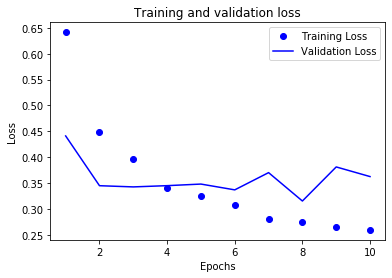

In [15]:
history_dict = history.history
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']

epochs = range(1, len(loss_values) + 1)

plt.plot(epochs, loss_values, 'bo', label='Training Loss') #bo es para blue dot
plt.plot(epochs, val_loss_values, 'b', label='Validation Loss') # b es para solid blue line
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.show()

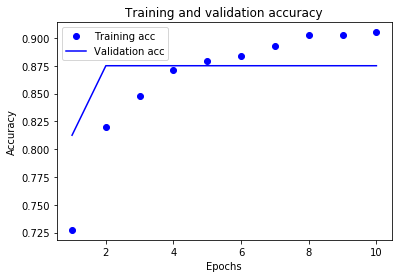

In [16]:
plt.clf()
acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']
plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.show()

## Final test

In [17]:
results = model.evaluate_generator(test_generator, steps=39)

In [18]:
print("Test Accuracy: ", results[1])

Test Accuracy:  0.900641


In [19]:
model.evaluate_generator(val_generator, steps=1)

[0.36241018772125244, 0.875]